# Detecting AI-generated content (AIGC)

**Author:** LAM Yan Yi, Elaine (57150480), HUNG Kai Hin (57137090), WONG Hoi Fai (57151396)

**Date:** 6-Dec-2024

## Table of Contents

1. [Introduction](#Introduction) <br>
2. [Feature Extraction](#feature-extraction) <br>
    2.1 [Error Level Analysis](#error-level-analysis-ela) <br>
    2.2 [Morphological Filter](#morphological-filter-mf) <br>
    2.3 [Local Binary Pattern](#local-binary-pattern) <br>
3. [Data Loader](#data-loader) <br>
    3.1 [Data Loading](#data-loading) <br>
    3.2 [Data Sampling](#data-sampling) <br>
4. [Model](#model)<br>
    4.1 [SE-ResNeXt Model](#SE-ResNeXt-Model)<br>
    4.2 [Ultralytics YOLO model](#Ultralytics-YOLO-model)<br>
5. [Result](#result)
6. [Discussion](#Discussion)
7. [Conclusion](#conculsion)

## Introduction
AI-generated content has been on the rise in both its popularity and its efficacy to deceive by false resemblance. Due to the rapid advancement in AI generation techniques, it has become harder and harder to differentiate between photorealistic and AI-created images. Our project aims to tackle this with our own implementation of an AI-Generated Content Detector. 

To further explain our ideas beyond basic code reading and explanation, we strive to provide a comprehensive view of our detector design and implementation, as well as, most importantly, the underlying reason for selecting such a design. The following report will delve into the importance of proper feature extraction in a well-designed network for achieving specific tasks. The report will explore our selection of feature extraction techniques and their respective crucial roles in filtering noise to ensure the fidelity of the images. Data loaders will also be discussed for their importance in effectively sampling data batches for training and validation. Our neural network model will also be introduced and thoroughly explained in the later sections. The report will also includes testing results from both our own test cases and official test results given back from TAs.

By the end of the report, readers will gain a more comprehensive understanding of the methodologies and technologies implemented in our design.

In [ ]:
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.transforms import v2
from torchvision import datasets, transforms

import timm
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import cv2
import numpy as np
import time
from sklearn import metrics

import zipfile
import fnmatch
from PIL import Image, ImageChops, ImageEnhance

#For texture extraction
from skimage import feature
import os
import csv
import logging
import datetime

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Setup logging
log_dir = 'log'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

current_datetime = datetime.datetime.now()
current_datetime_str = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")
log_file_path = os.path.join(log_dir, f"app_{current_datetime_str}.log")
logging.basicConfig(filename=log_file_path, level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')


## Feature Extraction
Feature extraction is a process to extract relevant information from raw data. Instead of putting every possible data into the model, a few selected features are used as input for the model. Unrelevant data is disregarded to reduce the drain on computational power and reduce the chances of confusing the network. The simplified data representation makes the training more efficient and quicker to complete, reducing training time.

However, choosing the suitable features to extract is no easy feat. Extracting unrelated features puts an unnecessary drain on the system and induces the possibility of confusing the training network. However, not extracting crucial features leaves the network pondering for more useful data and, therefore, unable to map useful connections between the inputs and the labels.

### Local Binary Pattern
Local binary pattern is a popular texture feature extraction technique used in the realm of machine learning and data analytics. It is able to provide a strong description of the local texture patterns within an image through comparing the central pixel with its neighbouring pixels to represent in a binary pattern. If the neighbouring pixels cross a threshold and are more intense than the centre pixel, a binary "1" is assigned. Through iterative computation of the local binary pattern for each of the pixels on the screen, the resulting output can accurately represent the local textural information stored within the image.

In [2]:
def extract_texture_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_image = gray_image.astype(np.uint8)  # Convert to integer type
    radius = 3
    n_points = 8 * radius
    lbp = feature.local_binary_pattern(gray_image, n_points, radius, method='uniform')

    lbp = lbp / lbp.max()  # Normalize the LBP values to the range [0, 1]
    
    return lbp

### Error Level Analysis (ELA)
Error level analysis is a common digital forensic technique to recognise images that have been tampered with or digitally altered. Error level analysis detects irregular distributions of quantisation noise to help identify possible regions of the image with a high concentration of inconsistencies in error level across the image.

Leveraging the ability of the error level analysis technique, we implemented it into our project as one of our feature extraction methods. It provided our system a way to highlight regions of interest that displayed a significant difference in in error levels. Due to the fact that AI-generated images often do not include natural imperfections found in real photos, it would serve a great purpose in providing information for the network to determine whether it is AI-generated or photorealistic images. 

In [3]:
def extract_color_features(image, quality=95, enhance_factor=10):
    temp_path = "temp_recompressed.jpg"
    image.save(temp_path, format="JPEG", quality=quality)
    with Image.open(temp_path) as recompressed:
        ela_image = ImageChops.difference(image, recompressed)
    os.remove(temp_path)

    enhancer = ImageEnhance.Brightness(ela_image)
    enhanced_ela = enhancer.enhance(enhance_factor)

    resized_ela = enhanced_ela.resize((224, 224)).convert("L")
    feature_array = np.array(resized_ela).astype(np.float32) / 255.0
    return feature_array

### Morphological Filter (MF)
Morphological filters are a class of image processing techniques used to analyse and process the shapes and structures within an image. There are two types of basic morphological filters as well as two advanced morphological filters that utilise the two basic ones in conjunction.

The first basic morphological filter is erosion. A morphological erosion filter is a robust technique for shrinking the boundaries of objects within an image. It decreases the amount of bright regions while increasing the amount of dark regions. 

The other form of basic morphological filter is dilation. A morphological dilation filter is highly capable in expanding the region of interest within an image. Reflecting a strong contrast from that of a morphological erosion filter, it increases the amount of bright regions while decreasing the amount of dark regions. 

We have decided to use opening as our method of feature extraction for our detection between AI-generated content and photorealistic images.

Opening combines erosion and dilation, where the input image first passes through a morphological erosion filter and then passes through a morphological dilation filter. Through the specific ordered combination of erosion and dilation, it is able to break apart narrow gaps between objects. An added benefit is small objects will be covered by the filter, allowing extraction only of the important major objects.

In [4]:
def extract_shape_features(image):
    kernel_size = 5
    transform_iteration = 5

    # Define the kernel
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    image = cv2.resize(image, (224, 224))  # Resize to (224, 224)

    image_dict = {}
    image_dict["original_image"] = image
    image_dict["eroded_image"] = cv2.erode(image_dict["original_image"], kernel, iterations=transform_iteration)
    image_dict["dilated_image"] = cv2.dilate(image_dict["original_image"], kernel, iterations=transform_iteration)
    image_dict["opened_image"] = cv2.dilate(image_dict['eroded_image'], kernel, iterations=transform_iteration)
    image_dict["closed_image"] = cv2.erode(image_dict['dilated_image'], kernel, iterations=transform_iteration)

    opened_image_resized = cv2.cvtColor(image_dict["opened_image"], cv2.COLOR_RGB2GRAY)

    return opened_image_resized  # Shape: (224, 224)


## Data Loader
### Data Loading
We implemented two data loaders, ZipImageFolderDataset and ImageFolderDataset, to handle our dataset efficiently. The ZipImageFolderDataset processes data directly from a zip file, while the ImageFolderDataset works with a pre-extracted folder. Both loaders iterate through the dataset to retrieve image file paths and assign labels based on the folder structure. Images in the "0_real" folder are labeled as photographic, and those in the "1_fake" folder are labeled as ai-generated image.

Our data loader iteratively goes through the data path, storing all of the image file paths, and their respective labels are assigned based on the folder they reside in. The image file paths are later opened to load the images as tensors. The tensors are converted to NumPy arrays to prepare for feature extraction. Before closing the image and disregarding the NumPy arrays, the arrays are passed through the three different feature extraction methods mentioned above. The three extracted feature channels are stacked and made into torch tensors to pass into the model for training. 

There is error checking to handle unforeseen cases of faulty image loading. If, for whatever reason, the image is unable to be converted to an image tensor, the system will log a critical logging message indicating what data type is received instead of the required tensor type. This not only explains to the user why the system has crashed but also provides helpful information to developers for an easier debugging process.

#### ZipImageFolderDataset
The ZipImageFolderDataset is designed to avoid extracting large zip archives, which can consume significant storage space. This loader dynamically locates image paths within the zip file and loads them on demand using Python’s zipfile module. However, processing images directly from the zip file introduces a computational overhead, making this loader slower than the folder-based approach.

In [5]:
def load_image_from_zip(zip_path, img_path):
    with zipfile.ZipFile(zip_path, 'r') as zf:
        with zf.open(img_path) as file:
            img = Image.open(file)
            return img.convert("RGB")  # Ensure the image is in RGB format
        
class ZipImageFolderDataset(datasets.ImageFolder):
    def __init__(self, zip_path, root, transform=None):
        self.zip_path = zip_path
        self.root = root
        self.transform = transform
        self.classes = ['0_real', '1_fake']
        self.img_paths = self._get_image_paths()

    def _get_image_paths(self):
        img_paths = []
        with zipfile.ZipFile(self.zip_path, 'r') as zf:
            for file_info in zf.infolist():
                name = file_info.filename
                if fnmatch.fnmatch(name, f"{self.root}/*.jpg"):
                    label = 0 if '0_real' in name.split('/')[1] else 1
                    img_paths.append((name, label))
        return img_paths

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img_path, label = self.img_paths[index]
        img = load_image_from_zip(self.zip_path, img_path)
        if self.transform:
            img_tensor = self.transform(img)
        
        # Ensure the image is now a tensor
        if not isinstance(img_tensor, torch.Tensor):
            raise TypeError(f"Expected image to be a tensor, but got {type(img_tensor)}.")
        
        # Convert tensor to numpy array for feature extraction
        img_np = img_tensor.numpy().transpose(1, 2, 0)
        
        # Extract features
        texture_features = extract_texture_features(img_np)
        color_features = extract_color_features(img)
        shape_features = extract_shape_features(img_np)
        
        features = np.stack([texture_features, color_features, shape_features], axis=0)
        features = torch.tensor(features).float().permute(1, 2, 0)  # Change the shape to [height, width, channels]
        features = features.permute(2, 0, 1)  # Change the shape to [channels, height, width]
        
        return features, label

#### ImageFolderDataset
The ImageFolderDataset operates on a pre-extracted folder structure. By accessing the unzipped files directly, this loader eliminates the need for runtime decompression, resulting in faster image loading. It is particularly efficient for scenarios where the dataset is accessed repeatedly or where speed is a critical factor.

In [6]:
class ImageFolderDataset(datasets.ImageFolder):
    def __init__(self, zip_path, root, transform=None):
        self.zip_path = zip_path
        self.root = root
        self.transform = transform
        self.classes = ['0_real', '1_fake']
        self.img_paths = self._get_image_paths()

    def _get_image_paths(roots):
        img_paths = []
        for root, dirs, files in os.walk(roots):
            for name in files:
                if fnmatch.fnmatch(name, "*.jpg"):
                    label = 0 if '0_real' in root else 1
                    img_paths.append((os.path.join(root, name), label))
        return img_paths

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img_path, label = self.img_paths[index]
        img = Image.open(img_path)
        if self.transform:
            img_tensor = self.transform(img)
        
        # Ensure the image is now a tensor
        if not isinstance(img_tensor, torch.Tensor):
            raise TypeError(f"Expected image to be a tensor, but got {type(img_tensor)}.")
        
        # Convert tensor to numpy array for feature extraction
        img_np = img_tensor.numpy().transpose(1, 2, 0)
        
        # Extract features
        texture_features = extract_texture_features(img_np)
        color_features = extract_color_features(img)
        shape_features = extract_shape_features(img_np)
        
        features = np.stack([texture_features, color_features, shape_features], axis=0)
        features = torch.tensor(features).float().permute(1, 2, 0)  # Change the shape to [height, width, channels]
        features = features.permute(2, 0, 1)  # Change the shape to [channels, height, width]
        
        return features, label

The implementation of both loaders ensures flexibility and adaptability. While the ZipImageFolderDataset reduces storage demands by working directly with compressed data, the ImageFolderDataset prioritizes speed and efficiency. By accommodating different needs, these loaders effectively handle diverse data scenarios and prepare the dataset for model training.

### Data Sampling
Not all of the data loaded is mixed together to be delivered to the network for training and validation. The training dataset is extracted and split into batches, randomising the order of the data with shuffling and then put into the network for training. The shuffling is done randomly and differently for each epoch, so the training data is different for each iteration of the training process. It gives the much-needed variety for the training data, allowing the network to have a more comprehensive view of the data. However, for the validation dataset, it is a drastically different story. For the validation dataset, we purposefully did not add random shuffling after each epoch. This is because the validating data has to be evaluated fairly between each epoch. Therefore, it is paramount that it stays the same to provide a static and unbiased view of the performance of the current epoch.

In [8]:
def load_data(zip_path, batch_size, image_size):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_dir = "AIGC-Detection-Dataset/train"
    val_dir = "AIGC-Detection-Dataset/val"
    # test_dir = "AIGC-Detection-Dataset/val"

    train_dataset = ZipImageFolderDataset(zip_path, train_dir, transform=transform)
    val_dataset = ZipImageFolderDataset(zip_path, val_dir, transform=transform)
    # test_dataset = ZipImageFolderDataset(zip_path, test_dir, transform=transform)
    print(f"Data prepared:\nTrain: {len(train_dataset)}, Val: {len(val_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    
    print("Data loaded")
    return train_loader, val_loader

## Model
The code for model training is provided below. 

We use two models (SE-ResNeXt and YOLOv11 model) to train and preform AI generated image detection. We use the same feature extraction mentioned above to train the two models and we would compare their performance at the end. 

### SE-ResNeXt Model
SE-ResNeXt is a neural network combining ResNext, Squeeze-and-Excitation blocks and the principle of cardinality for performing dynamic channel-wise feature recalibration. ResNeXt repeats building blocks that aggregate many transformations. 


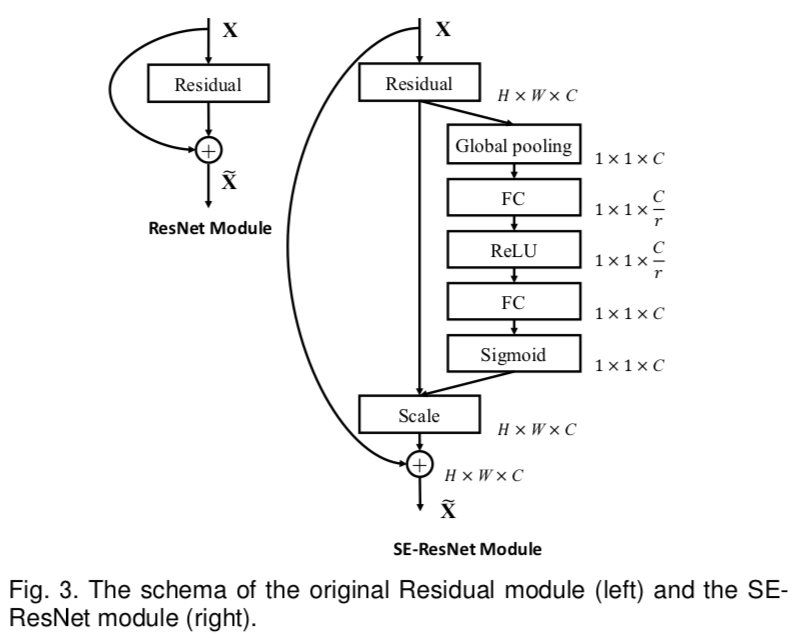
(Source: https://arxiv.org/pdf/1709.01507)


To achieve the goal of enhancing the representational power of the network, a parameter "cardinality" is implemented to control the paths through the network. Cardinality refers to the amount of parallel pathways within any given building block in the network. Through increasing the cardinality, it greatly improves the model's ability to capture a plethora of features without significantly increasing the number of parameters, allowing the network to better grasp the convoluted connections between features. It is achieved by enabling different paths that focus on various aspects of the input data. The increased cardinality effectively utilises the computation capacity to capture a broader range of features to ultimately enhance its representational power, leading to improved performance in sophisticated relationship mapping between features and labels. The implementation of the cardinality principle distinctly separates and distinguishes SE-ResNeXt from traditional ResNet networks.

ResNeXt is a neural network architecture extended from ResNet that introduces a new block structure. It puts a strong emphasis on parallelising the model to improve the scalability of the model. The improved scalability allows for more efficient use of computational power, increasing the performance of the model. The ResNeXt network consists of many blocks, where each block is comprised of a sequence of convolutional layers and ends after batch normalisation and the ReLU activation function is applied. For each of the blocks, the input data is separated into multiple channels based on the aforementioned cardinality parameter. The outputs are condensed before passing to the next block.

For Squeeze-and-Excitation block, it is a neural network component designed to provide a more comprehensive view of the features, thereby increasing the representational power of the network. It achieves a comprehensive view through adaptive recalibration of the feature maps. The "Squeeze" operation typically uses global average pooling to greatly reduce the spatial dimensionality of the feature maps to a 1x1 matrix. On the other hand, the "Excitation" operation learns a channel-wise/feature-wise weighting that encapsulates the significance of each of the given feature channels. The channel-wise weights are learnt through a smaller neural network. The Squeeze-and-Excitation block incorporates both the squeeze and excitation operations. The input feature maps are passed through the squeeze operation to obtain a channel-wise descriptor of the features. Then, it is passed through the excitation mechanism to learn the forenamed channel-wise weightings to scale the feature maps accordingly.

SE-ResNeXt combines the three factors mentioned above to achieve higher accuracy in image classification tasks. The SE blocks improve feature selection while allowing us to train our model with separated channels for various feature extraction methods. 

We follow the pretrained SE-ResNeXt101 (32x4d) architecture which works best with classification problems. The input convolution layer allows three-channel features where the input image size is 224x224. The layers are initiated by the pretrained model imported using timm. The model includes fully connected layer comprising 512 neurons, ReLU activation, dropout for regularization, and a final layer that outputs predictions for two classes. Here are more details for the model

This model features:
- ReLU as the activation function
- ReLU activations
- single layer 7x7 convolution with pooling
- 1x1 convolution shortcut downsample
- grouped 3x3 bottleneck convolutions
- Squeeze-and-Excitation channel attention

In [ ]:
class ModifiedSEResNeXt(nn.Module):
    def __init__(self, num_classes=2):
        super(ModifiedSEResNeXt, self).__init__()
        original_model = timm.create_model('seresnext101_32x4d', pretrained=True)

        original_conv1 = original_model.conv1
        self.conv1 = nn.Conv2d(
            in_channels=3,  # 3 channels for texture, color, and shape features
            out_channels=original_conv1.out_channels,
            kernel_size=original_conv1.kernel_size,
            stride=original_conv1.stride,
            padding=original_conv1.padding,
            bias=False
        )
        
        with torch.no_grad():
            self.conv1.weight = nn.Parameter(original_conv1.weight.mean(dim=1, keepdim=True).repeat(1, 3, 1, 1))
        
        self.bn1 = original_model.bn1
        self.act1 = original_model.act1
        self.maxpool = original_model.maxpool
        self.layer1 = original_model.layer1
        self.layer2 = original_model.layer2
        self.layer3 = original_model.layer3
        self.layer4 = original_model.layer4
        self.avg_pool = original_model.global_pool
        
        num_features = original_model.fc.in_features
        self.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avg_pool(x)
        x = x.flatten(1)
        x = self.fc(x)
        
        return x


#### Get model
The get_model function create and return a new SE-ResNeXt model if the model weight doesn't exit. If the model weight is inside the directory, it will load the weight from the given path, and return the loaded model.

In [ ]:
def get_model(filename='seresnext_finetuned.pth', force_new=False):
    file_path = os.path.join(os.getcwd(), filename)

    # Use pre-existing weights
    if os.path.exists(file_path) and not force_new:
        model = ModifiedSEResNeXt()
        model.load_state_dict(torch.load(file_path, map_location=DEVICE, weights_only=True))
        print(f"Loaded model weights from {file_path}")
        return model
    
    else:   # Create a new model
        model = ModifiedSEResNeXt()
        return model

##### Validation
In the AIGC-Detection-Databset, a validation set is included which is used validate the model during training by working as an unseen data for the model. Here is the validation function for calculating the loss and accuracy. The validation loss is useful in training the model to prevent overfitting.

In [ ]:
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE).float().unsqueeze(1)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            predicted = (outputs > 0.5).int()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    accuracy = correct / len(val_loader.dataset)
    return val_loss, accuracy

#### Saving model
The save_model function saves the weights and bias of the model to the desired path. We choose to save the state dictionary, it stores information about the optimizer’s state, as well as the hyperparameters used. This helps the model to be load for future actions like continue training and do predictions. 

The save_results function saves the training and validation loss and accuracy of each epoch into a csv file, which helps to visualize the training result.

In [ ]:
def save_model(model, path='testing.pth'):
    torch.save(model.state_dict(), path)
    print("Model saved successfully!")

def save_results(train_losses, val_losses, val_accuracies, path='results.csv'):
    with open(path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train Loss', 'Val Loss', 'Val Accuracy'])
        for i in range(len(train_losses)):
            writer.writerow([i+1, train_losses[i], val_losses[i], val_accuracies[i]])

#### Model Training 
For each epoch, the program process the training data in batches using train_loader. After each iteration, the validation loss and accuracy is calculated. If the validation loss is lower than the previous best, the current model would be saved, if not, it will be disposed. 

It returns the list of model's training loss, validation loss and validation accuracy during the entire training.

Here is the code for our model training. 

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs):
    model.train()
    best_val_loss = float('inf')
    patience = 5
    epochs_without_improvement = 0
    train_losses = []
    val_losses = []
    val_accuracies = []
    for epoch in range(epochs):
        running_loss = 0
        logging.info(f"Epoch {epoch+1} started...")
        logging.info(f"length of train_loader: {len(train_loader)}")
        start_time = time.time()
        
        batch = 1
        for features, labels in train_loader:
            # images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            features = features.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(features)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * features.size(0)
            logging.info(f'Batch {batch} completed, loss = {loss:.4f}')
            batch += 1
        
        epoch_loss = running_loss / len(train_loader.dataset)
        logging.info(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Time: {time.time()-start_time:.2f}s')
        train_losses.append(epoch_loss)
        
        val_loss, val_accuracy = validate_model(model, val_loader, criterion)
        logging.info(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            save_model(model, f'seresnent_e{epoch+1}.pth')
        else:
            epochs_without_improvement += 1
            
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        if epochs_without_improvement >= patience:
            logging.info(f"Early stopping at epoch {epoch + 1} due to no improvement in validation loss.")
            break
    return train_losses, val_losses, val_accuracies


#### Model Training Execution
For the execution, we uses the batch_size 64 for the training data. The epoch is set to 50. 

#### Criterion
We use CrossEntropyLoss as the loss function to compute the criterion. It penalizes the model for incorrect predictions which encourage the model to find the correct output.


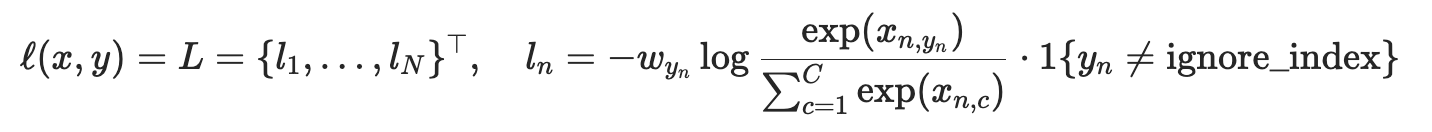
(Source: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

##### Optimizer
The optimizer is used for changing the model's parameters during training based on the gradients computed from the loss function. Adam optimizer is used here. It combines momentum-based techniques (first-order and second-order moments of the gradients) with learning rate = 0.0001.

In [ ]:
if __name__ == '__main__':
    # Start Training
    model_weight_filename = 'seresnext_finetuned.pth'
    
    model = get_model(model_weight_filename, force_new=False)
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(DEVICE)
    
    # Load the data
    zip_path = ''
    batch_size = 64
    image_size = 224
    train_loader, val_loader = load_data(zip_path, batch_size, image_size)
    
    criterion = nn.CrossEntropyLoss().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    
    train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, optimizer, criterion, 50)
    
    # Save the results to a CSV file
    save_results(train_losses, val_losses, val_accuracies)
    
    save_model(model, model_weight_filename)
    # evaluate(model, train_loader)
    # evaluate(model, val_loader)


#### Model Preformance Evaluation
The evaluate function calculates and returns the testing accuracy.

In [13]:
def evaluate(model, test_loader):
    # Validation phase
    model.eval()
    
    y_true = []
    y_pred = []
    
    for img, label in test_loader:
        # Please make sure that the "pred" is binary result
        output = model(img.to(DEVICE))
        pred = np.argmax(output.detach().to('cpu'), axis=1).numpy()
        
        y_true.extend(label.numpy())
        y_pred.extend(pred)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = metrics.accuracy_score(y_true, y_pred)
    return accuracy

In [ ]:
if __name__ == '__main__':
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    #path to the model weights
    model_weight_filename = r'..\some_result\seresnent_grp3.pth'
    
    model = get_model(model_weight_filename, force_new=False)
    model = model.to(DEVICE)
    
    # Load the data
    test_dataset_path = r'..\AIGC-Detection-Dataset\AIGC-Detection-Dataset\test'
    
    batch_size = 16 
    image_size = 224
    test_loader= load_data(test_dataset_path, batch_size, image_size)
    
    # Evaluate the model
    accuracy = evaluate(model, test_loader)
    print(f"Accuracy: {accuracy}")
    
    

c:\CS4487\.venv\Lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Loaded model weights from c:\CS4487\nn\..\some_result\seresnent_grp3.pth
Accuracy: 0.6875


### Ultralytics YOLO model
We use YOLO(You Only Look Once) model for the second part. YOLO is a family of real-time object detection models. It is a one-stage object detection models that process an entire image in a single forward pass of a convolutional neural network (CNN).
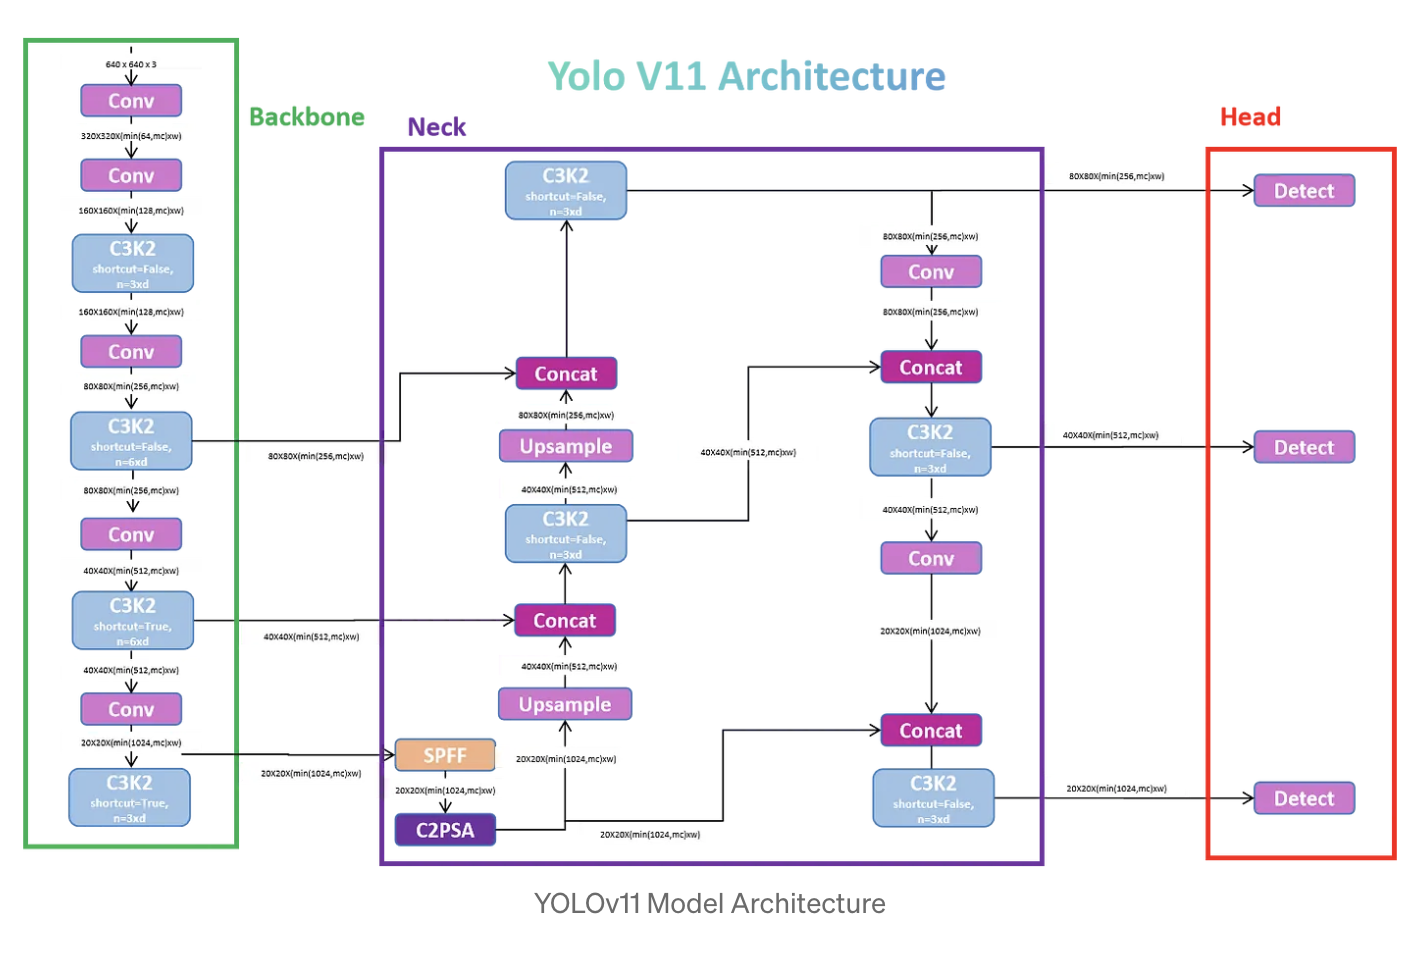
(reference: https://medium.com/@nikhil-rao-20/yolov11-explained-next-level-object-detection-with-enhanced-speed-and-accuracy-2dbe2d376f71)

YOLOv11 is one of the latest YOLO model. It can be used in classification, detection, segmentation, tracking and pose detection. 
In this usecase, we focus on using YOLO for classification problem: distinguish AI generated images and photos. 

In [ ]:
from ultralytics import YOLO
import torch
import os
import fnmatch
import numpy as np
from sklearn import metrics

#### YOLOv11 Model Training

##### Optimizer
The optimizer is used for changing the model's parameters during training based on the gradients computed from the loss function. Stochastic Gradient Descent (SGD) updates the parameters by moving them in the direction of the negative gradient of the loss function. The learning rate (lr=0.01) controls the step size of each update. Momentum (momentum=0.9) helps accelerate convergence.

##### Parameter Selecion
The YOLO model is default with different data augmentations to make its object detection better, such as give mask to the image, rotate the image, and shift the image. In our case, we disable all the data argument to keep the training images are same as the original input image. This improve the classification for about 2%.

In [ ]:
if __name__ == "__main__":
    # Load a model    
    model = YOLO("yolo11x-cls.pt", task='classify')
    
    data_path = 'AIGC-Detection-Dataset'
    # Train the model
    #embed to add our own feature extraction
    results = model.train(
            data=data_path, 
            epochs=40, 
            imgsz=224, 
            project='', 
            name='C:\CS4487\yololog', 
            overlap_mask=False, 
            save_period=1, 
            mask_ratio=0, 
            dropout=0.1,
            close_mosaic=40, 
            device=0, 
            rect=False,
            hsv_h=0, 
            hsv_s=0, 
            hsv_v=0, 
            translate=0,
            scale=0,
            fliplr=0, 
            erasing=0,
            mosaic=False,
            auto_augment=''
        )

#### Model Preformance Evaluation
The evaluate function calculates and returns the testing accuracy.

In [ ]:
def data_loder(path):
    img_paths = []
    labels = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, "*.jpg"):
                labels.append(0 if '0_real' in root else 1)
                img_paths.append(os.path.join(root, name))
    return (img_paths, labels)

In [ ]:
def evaluate(model, test_loader, batch_size):
    # Validation phase
    model.eval()
    
    y_true = np.array(test_loader[1])
    
    img_paths = test_loader[0]
    y_pred = []

    # Process images in batches
    for i in range(0, len(img_paths), batch_size):
        j = min(i + batch_size, len(img_paths))
        batch_paths = img_paths[i:j]
        results = model.predict(batch_paths, verbose=False)  # Predict batch
        y_pred.extend([result.probs.top1 for result in results])  # Collect predictions

    y_pred = np.array(y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    return accuracy

In [ ]:
def load_model(model_path):
    model = YOLO(model_path, task='classify', verbose=False)
    model.to(DEVICE)
    print(f'Model loaded from {model_path}')
    return model

In [ ]:
if __name__ == "__main__":
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
   
    #path to the model weights
    model_weight_filename = r'epoch3.pt'
    
    model = load_model(model_weight_filename)
    
    
    # Load the data
    test_dataset_path = r'..\AIGC-Detection-Dataset\test'
    batch_size = 512
    
    test_loader = data_loder(test_dataset_path)
    
    accuracy = evaluate(model, test_loader, batch_size)
    print(f"Accuracy: {accuracy}")

Model loaded from epoch3.pt
Accuracy: 0.6896551724137931


## Results
### SE-ResNeXt model
#### Validation result
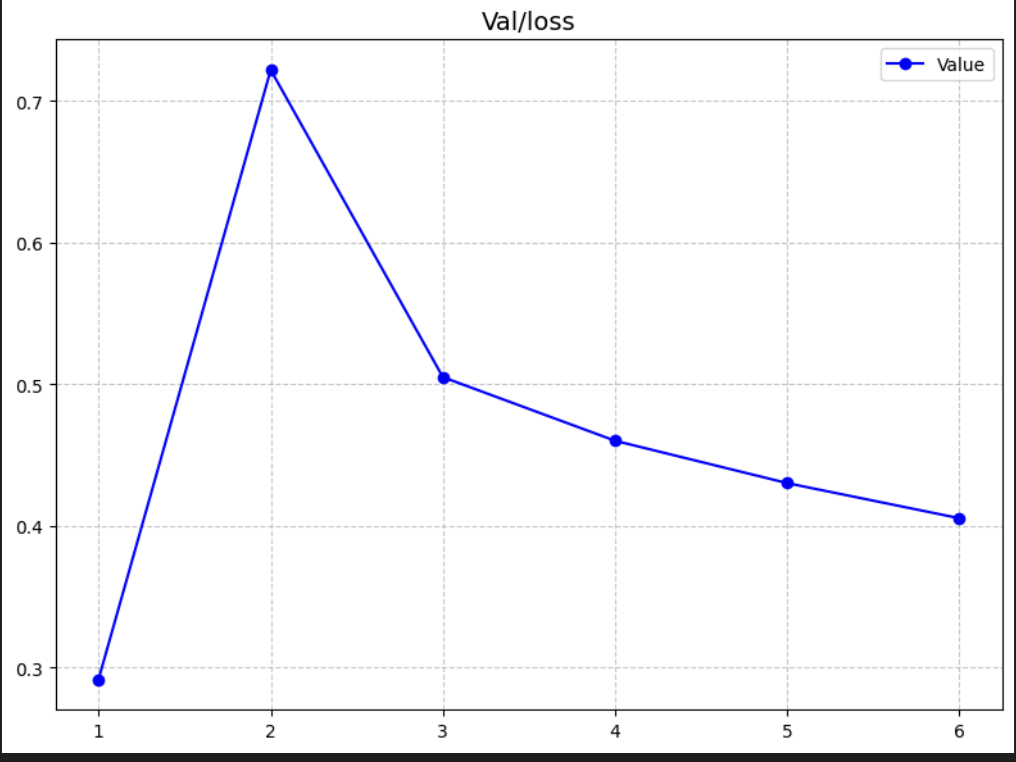

As we can observe from the graph, the validation loss was 0.2917 at epoch = 1. It increases intensly at epoch = 2 with the validation loss = 0.7219. We can observe at epoch from 2 to 6, the loss is in a decreasing trend. However, they could not outperform the first epoch. 

#### Testing result
The first submission rate:<br>
Intra-domain Test Accuracy: 0.9224<br>
Cross-domain Test Accuracy: 0.8422<br>
Average Test Accuracy: 0.8823<br>


### YOLOv11 model
#### Validation result
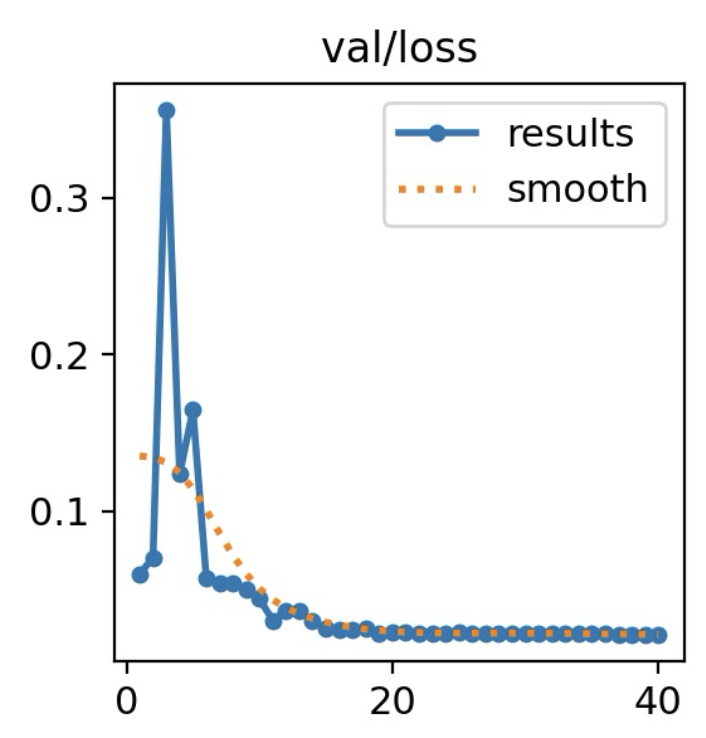

We can observe from the graph that the validation loss when epoch = 1 is 0.05976. The trend of the validation loss increases from epoch 1 to epoch 5. Then it gradually decreases and approach 0.0207 at the end. We can observe similar trend for both model regarding the validation loss. 

#### Testing result
The second submission rate (YOLOv11 model):<br>
Intra-domain Test Accuracy: 0.9559<br>
Cross-domain Test Accuracy: 0.8158<br>
Average Test Accuracy: 0.8858<br>


## Discussion
The SE-ResNeXt model and YOLOv11 model both serve the purpose of classifying AI-generated images and photorealistic images, but they differ significantly in their architecture and approach.

- **Architecture**: SE-ResNeXt uses a combination of ResNeXt blocks and SE blocks to enhance feature extraction, while YOLOv11 uses a single-stage detection approach optimized for speed and efficiency.
- **Performance**: SE-ResNeXt excels in cross-domain tests, indicating better generalization to diverse data. YOLOv11 performs better in intra-domain tests, showing high accuracy on data similar to the training set.
- **Use Case**: SE-ResNeXt is suitable for tasks requiring robust feature extraction and generalization, while YOLOv11 is ideal for real-time applications where speed is crucial.
- **Complexity**: SE-ResNeXt has a more complex architecture with multiple layers and blocks, which can lead to longer training times and higher computational requirements. YOLOv11, on the other hand, is designed for efficiency and speed, making it less computationally intensive.
- **Flexibility**: SE-ResNeXt's architecture allows for more flexibility in feature extraction, making it adaptable to various types of data and tasks. YOLOv11 is more specialized for object detection and classification tasks, with less flexibility in feature extraction.
- **Training Data**: SE-ResNeXt benefits from a diverse training dataset to fully leverage its feature extraction capabilities. YOLOv11 can achieve high performance with a more focused dataset, particularly for tasks similar to its training data.

In conclusion, both models have their strengths and are suitable for different scenarios. SE-ResNeXt offers better generalization and robustness, while YOLOv11 provides faster and more efficient classification for similar data.



## Conculsion
When using the SE-ResNeXt model, we can see an accuracy of 92% for intra-domain test and 84% for cross-domain test. For the second model, the accuracy is 95% for intra-domain test and 81% for cross-domain test. We can observe that the cross-domain test preforms generally worse than intra-domain test. It is logical since both models are trained on intra-domain images. 

Comparing the two models, YOLOv11 model is 3% more accurate regarding the intra-domain test and SE-ResNeXt model is 3% more accurate regarding the intra-domain test. We can conclude that SE-ResNeXt model is better in cross-domain test and YOLOv11 is better in Intra-domain test. 

In average, the two model have similar accuracy. 